In [2]:
# assign directory
import os
BRANDON = '/Users/brandonmarks/Desktop/Research Materials/hierarchical-bayesian-model-validation/'
YASH = '/Users/yashd/Desktop/hierarchical-bayesian-model-validation/'

ROOT_DIR = BRANDON
data_dir = ROOT_DIR + 'raw-data/toy-syntheticMRI-2D/axial-slice'
# iterate over files in that directory
file_list = [os.path.join(data_dir, filename) for filename in os.listdir(data_dir) if filename != ".DS_Store"]
file_names = os.listdir(data_dir)

In [3]:
from PIL import ImageFilter
from PIL.ExifTags import TAGS
import rembg

In [4]:
os.chdir(ROOT_DIR + "testing-framework/")
from utilities import *
from plot_utilities import *
os.chdir(ROOT_DIR + "dataset-preparation/")
from transform_utilities import *
from scipy import ndimage

In [4]:
coeffs, mags = convert_fourier_list(data_dir, c = 3)

In [5]:
real_data = np.real(coeffs)
imag_data = np.imag(coeffs)


In [6]:
def twoSampleComparisonPlots(samp1, samp2, bw =0.2, samp1name = "Sample 1", samp2name = "Sample 2"):
    n_1 = len(samp1)
    n_2 = len(samp2)
    ksres = stats.ks_2samp(samp1, samp2)
    ks_loc, ks_stat = ksres.statistic_location, ksres.statistic
    fig, axes = plt.subplots(1, 3, figsize=(24, 6))
    #axes[0].set_xlim(left = -.25*bound, right = .25*bound)
    #axes[1].set_xlim(left = -.25*bound, right = .25*bound)
    axes[1].set_ylim(bottom = 10**-6, top= 10)
    #axes[2].set_xlim(left = -.25*bound, right = .25*bound)
    sns.kdeplot(ax = axes[0], x = samp1, bw_method=bw, label = samp1name)
    sns.kdeplot(ax = axes[0], x = samp2,bw_method = bw, label = samp2name)
    sns.kdeplot(ax = axes[1], x = samp1, bw_method = bw, log_scale=[False, True], label = samp1name)
    sns.kdeplot(ax = axes[1], x = samp2, bw_method = bw, log_scale=[False, True], label = samp2name)
    axes[2].plot(np.sort(samp1), np.arange(1, n_1+1)/n_1, label=samp1name)
    axes[2].plot(np.sort(samp2), np.arange(1, n_2+1)/n_2, label=samp2name)
    emp_cdf_at_loc = np.searchsorted(np.sort(samp1), ks_loc, side='right') / n_1
    emp_cdf_at_loc2 = np.searchsorted(np.sort(samp2), ks_loc, side='right') / n_2
    axes[2].vlines(ks_loc, emp_cdf_at_loc, emp_cdf_at_loc2, linestyles='--', label=f'Maximum Deviation: {np.round(ks_stat, 6)}\nat x={np.round(ks_loc, 6)}', color='xkcd:bright red')
    
    axes[0].set_title("Non Log Scale Pdf")
    axes[1].set_title("Log Scale Pdf")
    axes[2].set_title(f"CDF with p-value:{np.round(ksres.pvalue, 8)}")
    axes[0].legend()
    axes[1].legend()
    axes[2].legend()

In [7]:
n= len(real_data)
n

24420000

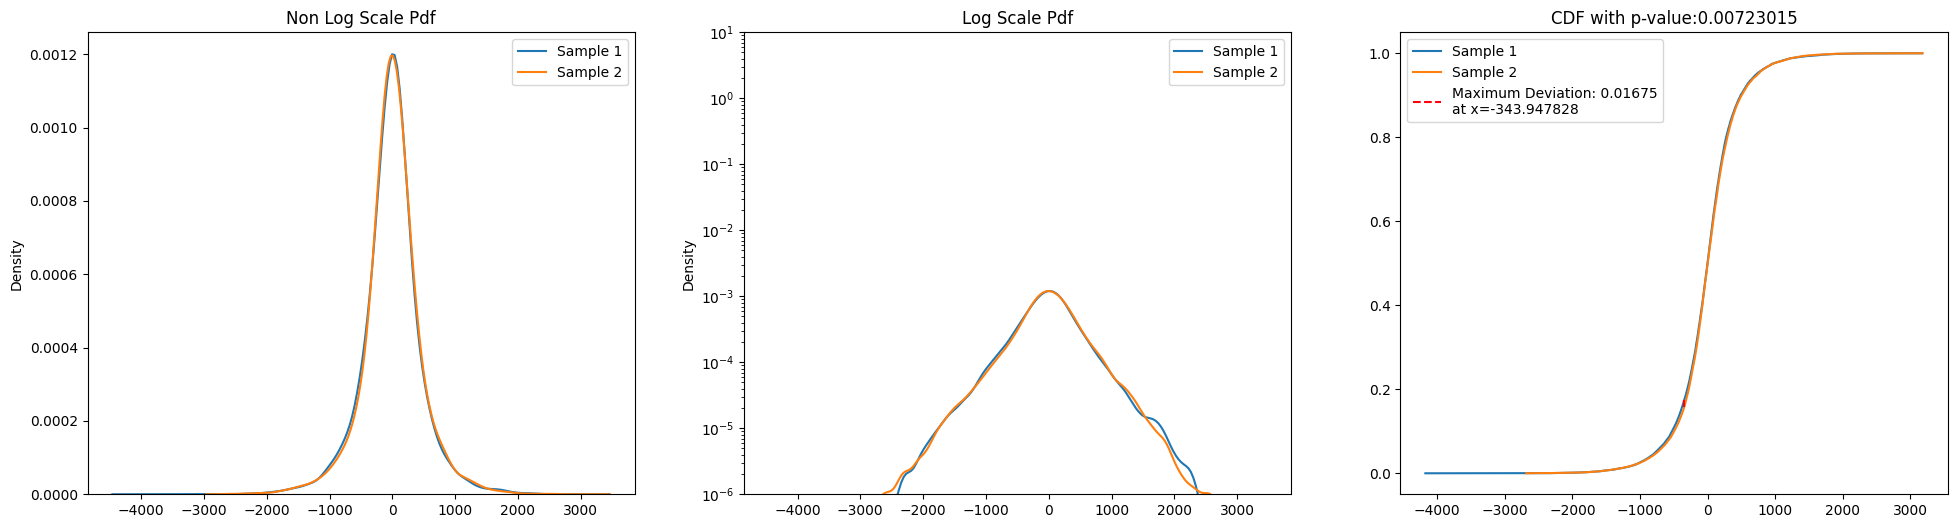

In [8]:

twoSampleComparisonPlots(real_data[n//2-10000:n//2+10000], imag_data[n//2-10000:n//2+10000])

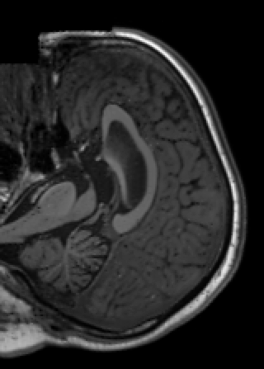

In [5]:
test_image = Image.open(file_list[1]).convert("L")
image_arr = np.array(test_image)
Image.fromarray(image_arr, 'L')


In [6]:
test_image_other = Image.open(file_list[1])
exifdata = test_image_other.getexif()
 
# looping through all the tags present in exifdata
for tagid in exifdata:
     
    # getting the tag name instead of tag id
    tagname = TAGS.get(tagid, tagid)
 
    # passing the tagid to get its respective value
    value = exifdata.get(tagid)
   
    # printing the final result
    print(f"{tagname:25}: {value}")

In [45]:
sum((image_arr[3:6, 3:6] != 0).flatten())

0

In [20]:
for i  in range(image_arr.shape[0]):
    for j in range(image_arr.shape[1]):
        if image_arr[i][j] ==0:
            image_arr[i][j] = 255

In [25]:
sum(image_arr.flatten() == 0)/ len(image_arr.flatten())

0.0

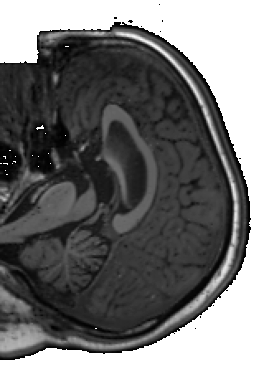

In [26]:
Image.fromarray(image_arr, 'L')

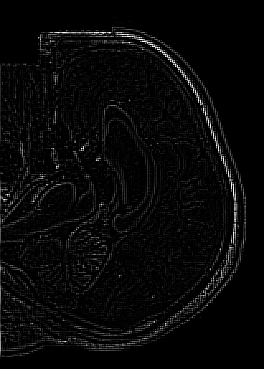

In [27]:
edges = test_image.filter(ImageFilter.FIND_EDGES)
edges

In [46]:
no_background = rembg.remove(test_image)


In [48]:
np.array(no_background)[:,:,3]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [3, 1, 0, ..., 0, 0, 0],
       [4, 1, 0, ..., 0, 0, 0]], dtype=uint8)

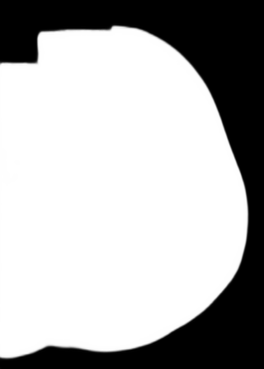

In [49]:
Image.fromarray(np.array(no_background)[:,:,3], 'L')

In [7]:
image_arr = np.array(test_image)
k = 1
imax = image_arr.shape[0]
jmax = image_arr.shape[1]
good_i = []
good_j = []
for i  in range(imax):
    for j in range(jmax):
        i_lower = max(0, i - k)
        i_upper = min(imax, i +k)
        j_lower = max(0, j-k)
        j_upper = min(jmax, j+k)
        frame = image_arr[i_lower:i_upper+1, j_lower:j_upper+1]
        if (frame != 0).any():
            good_i.append(i)
            good_j.append(j)

In [6]:
image_arr[tuple([good_i, good_j])] = 255

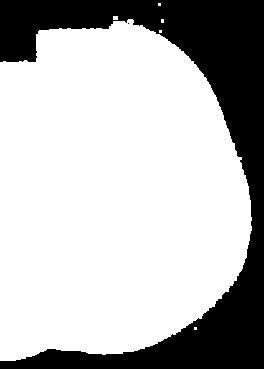

In [35]:
Image.fromarray(image_arr, 'L')

In [16]:
def ImageOutline(image_arr, k, l=0):
    image_arr_new = image_arr.copy().astype(float)
    imax = image_arr.shape[0]
    jmax = image_arr.shape[1]
    for i  in range(imax):
        for j in range(jmax):
            i_lower = max(0, i - k)
            i_upper = min(imax, i +k)
            j_lower = max(0, j-k)
            j_upper = min(jmax, j+k)
            frame = image_arr[i_lower:i_upper+1, j_lower:j_upper+1]
            if not (sum((frame != 0).flatten())>l):
                image_arr_new[i, j] = np.nan
    return image_arr_new

In [20]:
ImageOutline(image_arr, 2, l =1)


array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [48]:
image_arr = np.array(test_image)
image_arr

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

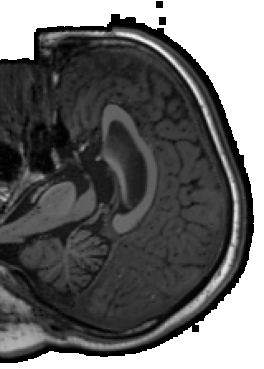

In [68]:
image_arr = np.array(test_image)
filtered = ndimage.uniform_filter(image_arr.astype("float"), size = 7)
image_arr[np.isclose(filtered, 0)] = 255
#image_arr[filtered != 0] = 0
Image.fromarray(image_arr, 'L')

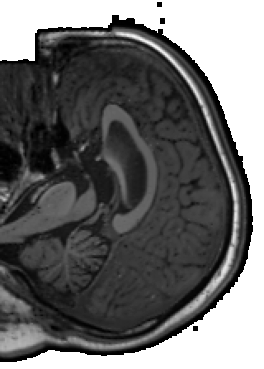

In [63]:
image_arr = np.array(test_image)
filtered = ndimage.uniform_filter(image_arr.astype("float"), size = 5)
image_arr[np.isclose(filtered, 0)] = 255
#image_arr[filtered != 0] = 0
Image.fromarray(image_arr, 'L')

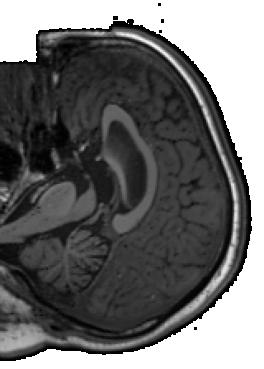

In [64]:
image_arr = np.array(test_image)
filtered = ndimage.uniform_filter(image_arr.astype("float"), size = 3)
image_arr[np.isclose(filtered, 0)] = 255
#image_arr[filtered != 0] = 0
Image.fromarray(image_arr, 'L')

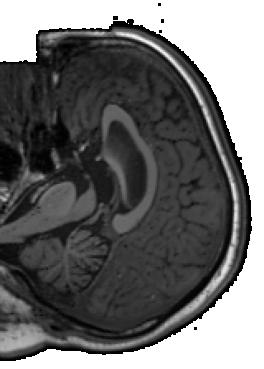

In [65]:
image_arr = np.array(test_image)
filtered = ndimage.maximum_filter(image_arr.astype("float"), size = 3)
image_arr[np.isclose(filtered, 0)] = 255
#image_arr[filtered != 0] = 0
Image.fromarray(image_arr, 'L')

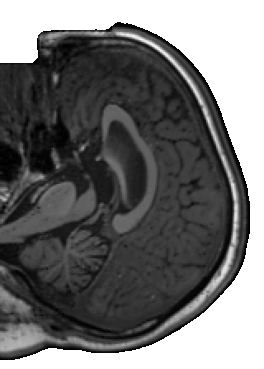

In [66]:
image_arr = np.array(test_image)
filtered = ndimage.median_filter(image_arr.astype("float"), size = 11)
image_arr[np.isclose(filtered, 0)] = 255
#image_arr[filtered != 0] = 0
Image.fromarray(image_arr, 'L')

In [34]:
for i in range(len(file_list)):
    image = np.array(Image.open(file_list[k]).convert('L')).astype(float)
    filtered = ndimage.uniform_filter(image, size = 7)
    image[filtered == 0] = np.nan